# Baseline Predictions for teacher churn 

A baseline prediction for teacher churn rates using Random Forest with basic feature selection. 

## Include libraries and helper functions

Load dependencies and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score

# Inputs
source_csv = '/home/andris/GitHub/data/churn_prediction/teacher_time_series.csv'

In [2]:
def prepare_df(df,date_feature, group_array,start_date,end_date):

    # Convert to datetime format
    df[date_feature] = pd.to_datetime(df[date_feature])

    # Select data from dates according to start_date and end_date
    df = df[df[date_feature]>= pd.to_datetime(start_date)]
    df = df[df[date_feature]<= pd.to_datetime(end_date)]

    # Group according to categories
    df_grp = df.groupby(group_array).count();

    # Unpack the indices into columns
    df_grp = df_grp.xs(date_feature, axis=1, drop_level=True)
    df_grp = df_grp.unstack().fillna(0)
  
    # Return the dataframe
    return df_grp

def prepare_time_series(df, month_array, type_operation, groupby_feature = 'user_id'):
    
    # If we want to append each month as a seperate feature 
    if type_operation == 'append':
        
        # Find the months of interest
        df_new = df[df.index.get_level_values(1).isin(month_array)].unstack().fillna(0)
        
        # Name new columns
        new_cols = [str(item[0]) + '_' + str(int(item[1])) for item in df_new.columns]
        
        # Drop level and rename
        df_new.columns = df_new.columns.droplevel(0)
        df_new.columns = new_cols
    
    # If we want to sum the values of each feature for every month
    elif type_operation == 'sum':
        df_new = df[df.index.get_level_values(1).isin(month_array)]
        df_new = df_new.reset_index().groupby(groupby_feature).sum()
    
    return df_new

## Load data and manipulate

In [3]:
# Load the dataframe 
df = pd.read_csv(source_csv)

# Grab the year and month of teacher registration
df_info = df[['user_id','registration_date']].drop_duplicates()
df_info['registration_date'] = pd.to_datetime(df_info['registration_date']) 
df_info['start_month'] = df_info['registration_date'].apply(lambda x:str(x.month))
df_info['start_year'] = df_info['registration_date'].apply(lambda x:x.year)

# Discretise (set time window)
dt = 30*24*3600
df['event_leg'] = np.floor((pd.to_datetime(df['date_created']) - pd.to_datetime(df['registration_date'])).dt.total_seconds()/dt)

# Group and create a new multi index dataframe  

start_date = '2014-08-01'
end_date = '2017-05-01'

df_grp = prepare_df(df,'date_created',['user_id','event_leg','event_type'],start_date,end_date)
df_grp.head()

event_type                                                    add_assig  \
user_id                                            event_leg              
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0             0.0   
                                                    0.0             0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0             0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0             0.0   
                                                    1.0             0.0   

event_type                                                    add_custom_assig  \
user_id                                            event_leg                     
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                    0.0   
                                                    0.0                    0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                    0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0                    0.0   
                                                    1.0                    0.0   

event_type                                                    add_user  \
user_id                                            event_leg             
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0            0.0   
                                                    0.0            0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0            0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0            0.0   
                                                    1.0            0.0   

event_type                                                    attempt  \
user_id                                            event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0           4.0   
                                                    0.0           3.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0           4.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0           8.0   
                                                    1.0           5.0   

event_type                                                    create_group  \
user_id                                            event_leg                 
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                0.0   
                                                    0.0                0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0                0.0   
                                                    1.0                0.0   

event_type                                                    view_assig_prog  
user_id                                            event_leg                   
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... -1.0                   0.0  
                                                    0.0                   0.0  
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d...  0.0                   0.0  
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c...  0.0                   0.0  
                                                    1.0                   0.0

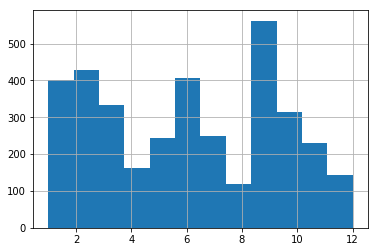

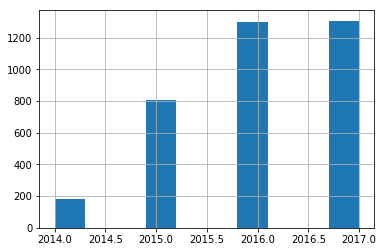

In [4]:
# Plotting the distribution of the start month and the start year

df_info['start_month'].apply(lambda x:int(x)).hist(bins=12)
plt.show()

df_info['start_year'].hist(bins=10)

In [5]:
## Add the events of event_leg -1 to 0

# Change the -1 event to 0
df_new = df_grp[df_grp.index.get_level_values(1)<0].reset_index()
df_new['event_leg'] = 0

# Add the dataframes together
df = df_grp.add(df_new.set_index(['user_id','event_leg']),fill_value=0)

# Removing event_leg = -1
df = df[df.index.get_level_values(1)>= 0]

df.head()

event_type                                                    add_assig  \
user_id                                            event_leg              
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0              0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0              0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0              0.0   
                                                   1.0              0.0   
                                                   4.0              0.0   

event_type                                                    add_custom_assig  \
user_id                                            event_leg                     
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                     0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                     0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                     0.0   
                                                   1.0                     0.0   
                                                   4.0                     0.0   

event_type                                                    add_user  \
user_id                                            event_leg             
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0             0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0             0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0             0.0   
                                                   1.0             0.0   
                                                   4.0             0.0   

event_type                                                    attempt  \
user_id                                            event_leg            
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0            7.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0            4.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0            8.0   
                                                   1.0            5.0   
                                                   4.0           16.0   

event_type                                                    create_group  \
user_id                                            event_leg                 
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                 0.0   
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                 0.0   
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                 0.0   
                                                   1.0                 0.0   
                                                   4.0                 0.0   

event_type                                                    view_assig_prog  
user_id                                            event_leg                   
00026a46eefde681a60b50bd7c2368c3091d035b2f56582... 0.0                    0.0  
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d... 0.0                    0.0  
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                    0.0  
                                                   1.0                    0.0  
                                                   4.0                    0.0

In [6]:
last_month = 0;

# Find users that have churned
plot_churn = df.reset_index().groupby('user_id')['event_leg'].max()

# Remove users that have churned before last month
plot_churn = plot_churn[plot_churn.values >= last_month]
df_lm = df.loc[plot_churn.index.values]

# Remove rows all greater than last_month
df_lm = df_lm[df_lm.index.get_level_values(1)<=last_month]
plot_churn =plot_churn.loc[np.unique(df_lm.index.get_level_values(0).values)]

# Label those that churned at last month
label = [1 if item == last_month else 0 for item in plot_churn.values]
df_lm = df_lm.loc[plot_churn.index.values]

# CLean off any nan
df_lm = df_lm.fillna(0)

# Add rows for months that may not exist for a user and set as zero
df_lm = df_lm.unstack(level='event_leg').stack(level='event_leg',dropna=False).fillna(0)

# Display the dataframe
df_lm.head(10)

,event_type,add_assig,add_custom_assig,add_user,attempt,create_group,view_assig_prog
user_id,event_leg,,,,,,
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,0.0,0.0,0.0,0.0,7.0,0.0,0.0
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d1663a47a8a9f1937f,0.0,0.0,0.0,0.0,4.0,0.0,0.0
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,0.0,8.0,0.0,0.0
001ee4c077e3972984ebddee5d8928ea3be07031025d61888f2f4c58f61179ee,0.0,0.0,1.0,1.0,6.0,0.0,3.0
0068f32c6dcbbdfa08c1b9cedc8d10b13f370725691cfdeb40e99c6c81d6056d,0.0,1.0,0.0,0.0,26.0,1.0,0.0
006a28f9870a964816db69d1bb9dda8be0cac871af2fdfc3c303179023a2e299,0.0,0.0,0.0,0.0,4.0,0.0,0.0
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de85b0764b714db2ba90,0.0,0.0,3.0,10.0,60.0,1.0,4.0
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c592c6f1fe2c5b7b0028,0.0,0.0,8.0,23.0,12.0,2.0,62.0
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6beba1546c8acc819591,0.0,0.0,0.0,0.0,4.0,0.0,0.0


In [7]:
# Prepare timeseries
df_lm_new = prepare_time_series(df_lm.groupby(['user_id','event_leg']).sum(),[0,1],'append')

# Add features
df_lm_new = df_lm_new.join(df_info.set_index('user_id')[['start_month','start_year']])

# Get dummies
df_lm_new = pd.get_dummies(df_lm_new)

print(df_lm_new.shape)

df_lm_new.head()


(2547, 19)


,add_assig_0,add_custom_assig_0,add_user_0,attempt_0,create_group_0,view_assig_prog_0,start_year,start_month_1,start_month_10,start_month_11,start_month_12,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9
user_id,,,,,,,,,,,,,,,,,,,
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,0.0,0.0,0.0,7.0,0.0,0.0,2015,0,0,0,1,0,0,0,0,0,0,0,0
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d1663a47a8a9f1937f,0.0,0.0,0.0,4.0,0.0,0.0,2017,1,0,0,0,0,0,0,0,0,0,0,0
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,8.0,0.0,0.0,2015,1,0,0,0,0,0,0,0,0,0,0,0
001ee4c077e3972984ebddee5d8928ea3be07031025d61888f2f4c58f61179ee,0.0,1.0,1.0,6.0,0.0,3.0,2017,0,0,0,0,0,0,1,0,0,0,0,0
0068f32c6dcbbdfa08c1b9cedc8d10b13f370725691cfdeb40e99c6c81d6056d,1.0,0.0,0.0,26.0,1.0,0.0,2016,0,0,0,0,0,0,0,0,0,0,1,0


(array([ 1118.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1429.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

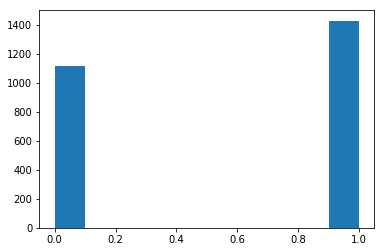

In [8]:
# Check class distribution
plt.hist(label)


(array([ 318.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  447.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

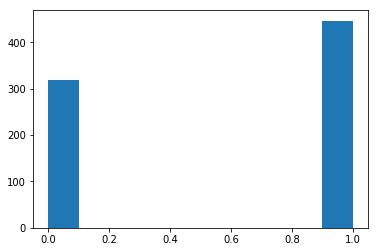

In [9]:
# Fill in any zeros
df_lm_new = df_lm_new.fillna(0)

# Assign data to auxillary variables
X = df_lm_new
y = label

# Storing the keys
store_keys = X.keys()

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X)
X = X_trf

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

plt.hist(y_test)

## Machine learning

Comparing results against random predictions.

In [10]:
# Do a test with a Dummy Classifier

clf = DummyClassifier(strategy='constant', constant=1)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate

print(classification_report(y_pred,y_test))

clf = DummyClassifier(strategy='stratified')
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate

print(classification_report(y_pred,y_test))



             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.58      0.74       765

avg / total       1.00      0.58      0.74       765

             precision    recall  f1-score   support

          0       0.43      0.40      0.42       345
          1       0.54      0.57      0.55       420

avg / total       0.49      0.49      0.49       765



/home/work/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.59077763145297968

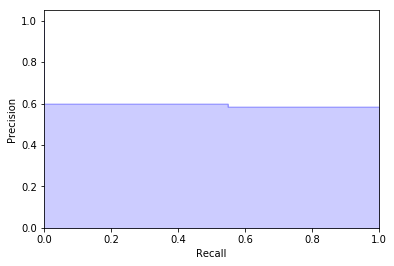

In [11]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

average_precision_score(y_test,y_score[:,1])

             precision    recall  f1-score   support

          0       0.66      0.67      0.66       312
          1       0.77      0.76      0.76       453

avg / total       0.72      0.72      0.72       765



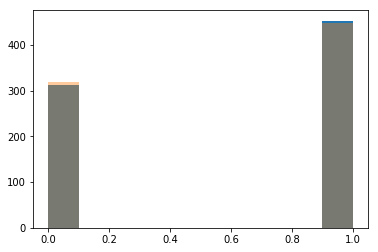

In [12]:
# Classifier
clf = RF(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate
plt.hist(y_pred)
plt.hist(y_test,alpha= 0.4)

print(classification_report(y_pred,y_test))


0.846037546838
@ 0.5
True positives: 412
True negatives: 120
False negatives: 35
False positives: 198
Precision is: 0.675409836066
Recall is: 0.921700223714


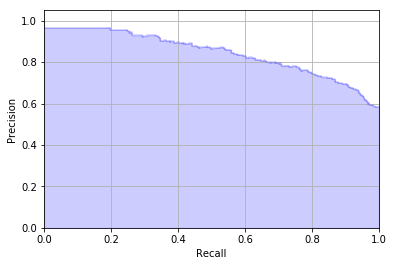

In [13]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid()

print(average_precision_score(y_test,y_score[:,1]))

def calculate_errors(y_test,y_pred):

    true_pos = 0;
    true_neg = 0
    false_neg = 0;
    false_pos = 0
    for item in range(len(y_test)):

        if y_test[item] == 1:

            if y_test[item] == y_pred[item]:
                true_pos +=1

            else:
                false_neg +=1

        if y_test[item] == 0:

            if y_test[item] == y_pred[item]:
                true_neg +=1

            else:
                false_pos += 1

    print('True positives:',true_pos)
    print('True negatives:',true_neg)
    print('False negatives:',false_neg)
    print('False positives:',false_pos)

    
y_pred2 = [1 if item > 0.2 else 0 for item in y_score[:,1]]

print('@ 0.5')
calculate_errors(y_test,y_pred2)
print('Precision is:',precision_score(y_test,y_pred2))
print('Recall is:',recall_score(y_test,y_pred2))

In [14]:
precision

array([ 0.58431373,  0.58520476,  0.5862069 ,  0.58643617,  0.58744993,
        0.59084791,  0.5916442 ,  0.59349593,  0.59294437,  0.59375   ,
        0.60027663,  0.59972299,  0.60055479,  0.60390516,  0.6047486 ,
        0.60559441,  0.60618847,  0.60704225,  0.61134752,  0.61221591,
        0.6169297 ,  0.61781609,  0.61870504,  0.61849711,  0.62028986,
        0.62701909,  0.62794118,  0.62886598,  0.62979351,  0.63392857,
        0.63487332,  0.6367713 ,  0.63772455,  0.63718141,  0.63813814,
        0.64048338,  0.64145234,  0.64242424,  0.64624809,  0.65123457,
        0.65069552,  0.6501548 ,  0.65217391,  0.65830721,  0.65934066,
        0.66192733,  0.66297468,  0.66402536,  0.66613672,  0.66719745,
        0.66881029,  0.66988728,  0.66935484,  0.67263844,  0.67373573,
        0.67540984,  0.67651888,  0.67545305,  0.67656766,  0.67715232,
        0.67940199,  0.68113523,  0.68235294,  0.68350168,  0.6846543 ,
        0.68581081,  0.68697124,  0.68813559,  0.6893039 ,  0.69

0.793687476257


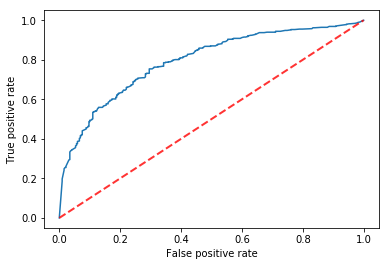

In [15]:

fpr, tpr, thresholds = roc_curve(y_test,y_score[:,1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

print(roc_auc_score(y_test,y_score[:,1]))



## Feature extraction

Checking the importance of each feature and retraining model.

Standard and with BorutaPy.

In [314]:
# Get the feature importance

# Output feature importance

def return_feature_importance(X,y,keys,n_estimators = 100):

    # Using the random forest classifier, find out what are the main features that predict whether a user is likely to churn or not
    randomForest = RF(n_estimators)
    randomForest.fit(X,y)
    
    importances = randomForest.feature_importances_
    
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),keys[indices[f]])

return_feature_importance(X,y,store_keys)

Feature ranking:
1. feature 12 (0.176523) start_year
2. feature 7 (0.113809) attempt_1
3. feature 6 (0.098454) attempt_0
4. feature 5 (0.067167) add_user_1
5. feature 11 (0.065452) view_assig_prog_1
6. feature 4 (0.065214) add_user_0
7. feature 8 (0.058514) create_group_0
8. feature 10 (0.049370) view_assig_prog_0
9. feature 2 (0.045835) add_custom_assig_0
10. feature 9 (0.040485) create_group_1
11. feature 3 (0.039493) add_custom_assig_1
12. feature 0 (0.023156) add_assig_0
13. feature 18 (0.018706) start_month_3
14. feature 1 (0.016856) add_assig_1
15. feature 24 (0.015640) start_month_9
16. feature 13 (0.015218) start_month_1
17. feature 14 (0.015136) start_month_10
18. feature 15 (0.013869) start_month_11
19. feature 16 (0.012712) start_month_12
20. feature 17 (0.012209) start_month_2
21. feature 21 (0.012099) start_month_6
22. feature 20 (0.008988) start_month_5
23. feature 19 (0.006740) start_month_4
24. feature 22 (0.005744) start_month_7
25. feature 23 (0.002611) start_month_8


In [315]:
# Using the boprutaPy package

from boruta import BorutaPy

rf = RF(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	8
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	8
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	8
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	8
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15
Iteration: 	99 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	9
Tentative: 	1
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=89, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7f89450ca318>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7f89450ca318>,
     two_step=True, verbose=2)

In [316]:
# Print the columns that were found to be important
print(df_lm_new.columns[feat_selector.support_])

# Get the rank
print(pd.DataFrame({'name':df_lm_new.columns,'rank':feat_selector.ranking_}).sort_values('rank'))

# Transform X
X_filtered = feat_selector.transform(X)


Index(['add_user_0', 'add_user_1', 'attempt_0', 'attempt_1', 'create_group_0',
       'create_group_1', 'view_assig_prog_1', 'start_year', 'start_month_6'],
      dtype='object')
                  name  rank
12          start_year     1
4           add_user_0     1
5           add_user_1     1
6            attempt_0     1
7            attempt_1     1
8       create_group_0     1
9       create_group_1     1
11   view_assig_prog_1     1
21       start_month_6     1
2   add_custom_assig_0     2
3   add_custom_assig_1     3
10   view_assig_prog_0     4
18       start_month_3     5
1          add_assig_1     6
17       start_month_2     6
0          add_assig_0     8
24       start_month_9     8
22       start_month_7    10
13       start_month_1    11
16      start_month_12    12
14      start_month_10    12
15      start_month_11    14
20       start_month_5    15
23       start_month_8    16
19       start_month_4    17


             precision    recall  f1-score   support

          0       0.94      0.90      0.92       320
          1       0.45      0.58      0.51        43

avg / total       0.88      0.87      0.87       363



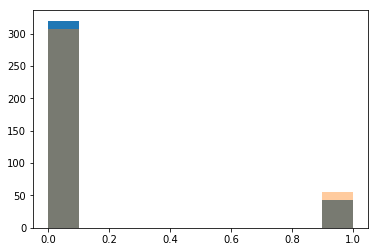

In [317]:
# Let's train and evaluate the model

# Assign
X = X_filtered

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X_filtered)
X = X_trf

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

# Classifier
clf = RF(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate
plt.hist(y_pred)
plt.hist(y_test,alpha= 0.4)

print(classification_report(y_pred,y_test))


0.58779645764468746

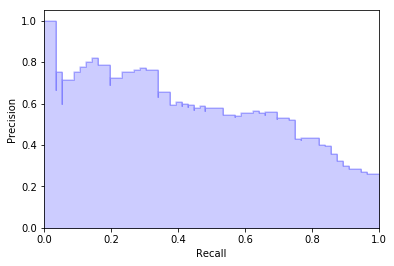

In [318]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

average_precision_score(y_test,y_score[:,1])


## Additional features

Here we import a dataframe that has more features for each user.

In [13]:
source_user = '/home/work/GitHub/data/user_info.csv'

df = pd.read_csv('/home/work/GitHub/data/teacher_churn/edit_teacher_timeseries.csv')

df.head()

,index,event_leg,add_assig,add_custom_assig,add_user,create_group,play_video,q_lvl_0,q_lvl_0_cor,q_lvl_1,...,q_lvl_3_cor,q_lvl_4,q_lvl_4_cor,q_lvl_5,q_lvl_5_cor,q_lvl_6,q_lvl_6_cor,view_assig_prog,view_concept,view_hint
0,00026a46eefde681a60b50bd7c2368c3091d035b2f5658...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
1,0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,17.0
3,001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0
4,001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726...,4.0,0.0,0.0,0.0,0.0,4.0,4.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Grabbing the registration date of each user

df_user = pd.read_csv(source_user)

df_user = df_user.set_index('id')
df_user['registration_date'] = pd.to_datetime(df_user['registration_date'])
df_user['start_month'] = df_user['registration_date'].apply(lambda x:str(x.month))
df_user['start_year'] = df_user['registration_date'].apply(lambda x:x.year)

df_user = df_user[['start_month','start_year']]
df_user.head()

,start_month,start_year
id,,
d94c077ad88fc2b7a1204ba16c30f93961d86ededecbb47bef25063cb4835c12,11,2015
1ef02c359b5b66b584da8d46d1f790f509eeb55b80a908b6d3c3ad4c758b216b,10,2015
eed0d25033826f9786fc61daef41f9f6c0046248254e3c348a08bcb83b11ffb1,12,2015
5937dd6ec7778da3dc7cc63303439bcc6a622da83fdf4afdadfd6586c31af1e7,11,2015
68a983c9bfca031c77b2159cf651a624a893a02cc79bdd0624effddc2d3ff699,4,2015


In [28]:
last_month = 0;

# Find users that have churned
plot_churn = df.reset_index().groupby('index')['event_leg'].max()

# Remove users that have churned before last month
plot_churn = plot_churn[plot_churn.values >= last_month]
df_lm = df.set_index(['index','event_leg']).loc[plot_churn.index.values]

# Remove rows all greater than last_month
df_lm = df_lm[df_lm.index.get_level_values(1)<=last_month]
plot_churn =plot_churn.loc[np.unique(df_lm.index.get_level_values(0).values)]

# Label those that churned at last month
label = [1 if item == last_month else 0 for item in plot_churn.values]
df_lm = df_lm.loc[plot_churn.index.values]

# CLean off any nan
df_lm = df_lm.fillna(0)

# Add rows for months that may not exist for a user and set as zero
df_lm = df_lm.unstack(level='event_leg').stack(level='event_leg',dropna=False).fillna(0)

# Display the dataframe
df_lm.head(10)


,,add_assig,add_custom_assig,add_user,create_group,play_video,q_lvl_0,q_lvl_0_cor,q_lvl_1,q_lvl_1_cor,q_lvl_2,...,q_lvl_3_cor,q_lvl_4,q_lvl_4_cor,q_lvl_5,q_lvl_5_cor,q_lvl_6,q_lvl_6_cor,view_assig_prog,view_concept,view_hint
index,event_leg,,,,,,,,,,,,,,,,,,,,,
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d1663a47a8a9f1937f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,17.0
001ee4c077e3972984ebddee5d8928ea3be07031025d61888f2f4c58f61179ee,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0
0068f32c6dcbbdfa08c1b9cedc8d10b13f370725691cfdeb40e99c6c81d6056d,0.0,1.0,0.0,0.0,1.0,1.0,4.0,4.0,5.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
006a28f9870a964816db69d1bb9dda8be0cac871af2fdfc3c303179023a2e299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
00ab0f1d045f05764b9731a67758d9b401c234ffe7b5de85b0764b714db2ba90,0.0,0.0,3.0,10.0,1.0,0.0,26.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
00d7b52c5e872c5f09ffe70b1c0d5b99b79e4021b5b0c592c6f1fe2c5b7b0028,0.0,0.0,8.0,23.0,2.0,0.0,4.0,2.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,1.0,8.0
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6beba1546c8acc819591,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0


In [29]:
# Prepare timeseries
df_lm_new = prepare_time_series(df_lm.groupby(['index','event_leg']).sum(),[0,1],'append')

# Adding features
df_lm_new = df_lm_new.join(pd.get_dummies(df_user))

df_lm_new.head()


,add_assig_0,add_custom_assig_0,add_user_0,create_group_0,play_video_0,q_lvl_0_0,q_lvl_0_cor_0,q_lvl_1_0,q_lvl_1_cor_0,q_lvl_2_0,...,start_month_11,start_month_12,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9
index,,,,,,,,,,,,,,,,,,,,,
00026a46eefde681a60b50bd7c2368c3091d035b2f565824640272c89eb6916a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
0018d184ff3b1f2336ebeac5646d13ca84de10d034adc5d1663a47a8a9f1937f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
001ee4c077e3972984ebddee5d8928ea3be07031025d61888f2f4c58f61179ee,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
0068f32c6dcbbdfa08c1b9cedc8d10b13f370725691cfdeb40e99c6c81d6056d,1.0,0.0,0.0,1.0,1.0,4.0,4.0,5.0,13.0,0.0,...,0,0,0,0,0,0,0,0,1,0


(array([ 1260.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1478.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

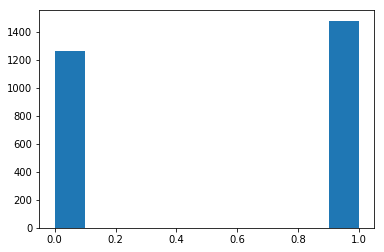

In [30]:
# Check class distribution
plt.hist(label)


(array([ 372.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  450.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

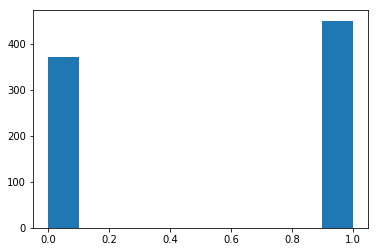

In [31]:
# Fill in any zeros
df_lm_new = df_lm_new.fillna(0)

# Assign data to auxillary variables
X = df_lm_new
y = label

# Storing the keys
store_keys = X.keys()

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X)
X = X_trf

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

plt.hist(y_test)

             precision    recall  f1-score   support

          0       0.70      0.71      0.71       368
          1       0.76      0.76      0.76       454

avg / total       0.74      0.73      0.73       822



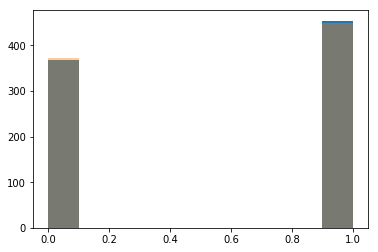

In [32]:
# Classifier
clf = RF(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate
plt.hist(y_pred)
plt.hist(y_test,alpha= 0.4)

print(classification_report(y_pred,y_test))


0.81574205297310642

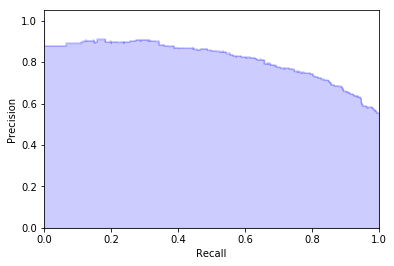

In [33]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

average_precision_score(y_test,y_score[:,1])

In [34]:
# Using the boprutaPy package

from boruta import BorutaPy

rf = RF(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	35
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	14


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	15


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 100
Confirmed: 	15
Tentative: 	4
Rejected: 	16


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17
Iteration: 	99 / 100
Confirmed: 	15
Tentative: 	3
Rejected: 	17


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	17


/home/work/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x7f9ff0e1e7e0>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x7f9ff0e1e7e0>,
     two_step=True, verbose=2)

In [35]:
# Print the columns that were found to be important
print(df_lm_new.columns[feat_selector.support_])

# Get the rank
print(pd.DataFrame({'name':df_lm_new.columns,'rank':feat_selector.ranking_}).sort_values('rank'))

# Transform X
X_filtered = feat_selector.transform(X)


Index(['add_assig_0', 'add_custom_assig_0', 'add_user_0', 'create_group_0',
       'play_video_0', 'q_lvl_0_0', 'q_lvl_0_cor_0', 'view_assig_prog_0',
       'view_concept_0', 'view_hint_0', 'start_year', 'start_month_1',
       'start_month_2', 'start_month_3', 'start_month_9'],
      dtype='object')
                  name  rank
0          add_assig_0     1
28       start_month_3     1
27       start_month_2     1
23       start_month_1     1
22          start_year     1
21         view_hint_0     1
20      view_concept_0     1
19   view_assig_prog_0     1
34       start_month_9     1
5            q_lvl_0_0     1
1   add_custom_assig_0     1
2           add_user_0     1
3       create_group_0     1
4         play_video_0     1
6        q_lvl_0_cor_0     1
10       q_lvl_2_cor_0     2
12       q_lvl_3_cor_0     2
8        q_lvl_1_cor_0     3
14       q_lvl_4_cor_0     4
31       start_month_6     5
7            q_lvl_1_0     5
17           q_lvl_6_0     7
9            q_lvl_2_0     8
11

             precision    recall  f1-score   support

          0       0.68      0.68      0.68       373
          1       0.74      0.74      0.74       449

avg / total       0.71      0.71      0.71       822



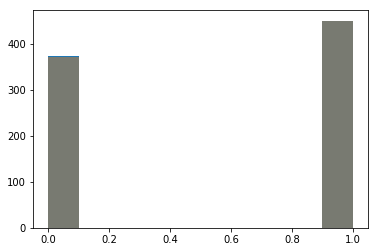

In [36]:
# Let's train and evaluate the model

# Assign
X = X_filtered

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X_filtered)
X = X_trf

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

# Classifier
clf = RF(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate
plt.hist(y_pred)
plt.hist(y_test,alpha= 0.4)

print(classification_report(y_pred,y_test))


0.80637384278342261

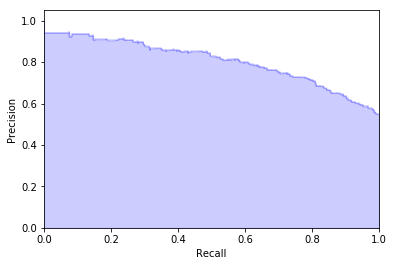

In [37]:
precision, recall, _ = precision_recall_curve(y_test,y_score[:,1])


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

average_precision_score(y_test,y_score[:,1])
